# Attempts about finding aspects that can influence the effects of Music Therapy

Author: Mingyu Chen

Course Project, UC Irvine, Math 10, F22

## Introduction

I was attracted by this dataset in kaggle with this link, and I realize there are a lot of perspectives that may influence the effects of music therapy. I'd love to try if I can find the connections and relationships between the music effects and those various relevant factors.

https://www.kaggle.com/datasets/catherinerasgaitis/mxmh-survey-results

To start my research, I first made some changes with the dataframe to make it more convenient for me to analyze, and then I tried to find possible factors with mainly three directions: respondents' ages and frequency of listening, the various kinds of music (with different BPM), and respondents' mental health conditions.

## Preparation and the processing on the dataset
In this part, I'd love to make some changes with the dataset so it can be analyzed easily and efficiently.

In [1]:
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns


from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
df = pd.read_csv("mxmh_survey_results.csv").dropna(axis=0)

In [3]:
df.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.
5,8/27/2022 21:56:50,18.0,Spotify,5.0,Yes,Yes,Yes,Jazz,Yes,Yes,...,Very frequently,Very frequently,Very frequently,Never,8.0,8.0,7.0,7.0,Improve,I understand.
6,8/27/2022 22:00:29,18.0,YouTube Music,3.0,Yes,Yes,No,Video game music,Yes,Yes,...,Rarely,Never,Never,Sometimes,4.0,8.0,6.0,0.0,Improve,I understand.


In this dataframe, we can find that there is a lot of data like "yes", "no" and "rarely", which are good to read but may not be so easy to process and work on. Therefore, I'd love to change them to be numbers before data analysis.

In [4]:
df1 = df.copy()

In [5]:
# change the format of "Timestamps"
df1["Timestamp"] = df1["Timestamp"].map(lambda x: pd.to_datetime(x))

In [6]:
#replace "yes"/"no" with "1"/"0"
df1.replace(('Yes', 'No'), (1, 0), inplace=True) # reference, source 1

In [7]:
# replace the words of frequency
df1.replace(('Never', 'Rarely', 'Sometimes', 'Very frequently'), (0,1,2,3), inplace=True) 

In [8]:
df1.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
2,2022-08-27 21:28:18,18.0,Spotify,4.0,0,0,0,Video game music,0,1,...,0,1,1,3,7.0,7.0,10.0,2.0,No effect,I understand.
3,2022-08-27 21:40:40,61.0,YouTube Music,2.5,1,0,1,Jazz,1,1,...,2,0,0,0,9.0,7.0,3.0,3.0,Improve,I understand.
4,2022-08-27 21:54:47,18.0,Spotify,4.0,1,0,0,R&B,1,0,...,3,3,0,1,7.0,2.0,5.0,9.0,Improve,I understand.
5,2022-08-27 21:56:50,18.0,Spotify,5.0,1,1,1,Jazz,1,1,...,3,3,3,0,8.0,8.0,7.0,7.0,Improve,I understand.
6,2022-08-27 22:00:29,18.0,YouTube Music,3.0,1,1,0,Video game music,1,1,...,1,0,0,2,4.0,8.0,6.0,0.0,Improve,I understand.


Check and drop if there are outliers by using Boolean Indexing:

In [9]:
df1.shape # orginal shape of dataframe before removing the outliers

(616, 33)

In [10]:
# Find the first outlier with the original data
arr = df1["BPM"]
s = arr.std()
outlier = arr[np.abs(arr - arr.mean()) > 5*s]
outlier

568    999999999.0
Name: BPM, dtype: float64

It's easy to realize there indeed have outliers, like the extremely large number of BPM here. We will use a while loop to repeat this code until there's no more outliers in our standard of checking.

In [11]:
df1.index

Int64Index([  2,   3,   4,   5,   6,   7,   8,   9,  11,  13,
            ...
            726, 727, 728, 729, 730, 731, 732, 733, 734, 735],
           dtype='int64', length=616)

In [12]:
# Using a while loop to get out of the outliers.
while len(outlier) > 0:
    arr = df1["BPM"]
    s = arr.std()
    outlier = arr[np.abs(arr - arr.mean()) > 5*s]
    df1 = df1.drop(index = outlier.index);
    #repeat run this cell until len(outlier) = 0
else:
    print(f"Now the amount of outliers in df1 is {len(outlier)}")


Now the amount of outliers in df1 is 0


In [13]:
df1.shape # the shape of df1 changed, so we know we indeed dropped the outliers

(614, 33)

In [14]:
df1.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
2,2022-08-27 21:28:18,18.0,Spotify,4.0,0,0,0,Video game music,0,1,...,0,1,1,3,7.0,7.0,10.0,2.0,No effect,I understand.
3,2022-08-27 21:40:40,61.0,YouTube Music,2.5,1,0,1,Jazz,1,1,...,2,0,0,0,9.0,7.0,3.0,3.0,Improve,I understand.
4,2022-08-27 21:54:47,18.0,Spotify,4.0,1,0,0,R&B,1,0,...,3,3,0,1,7.0,2.0,5.0,9.0,Improve,I understand.
5,2022-08-27 21:56:50,18.0,Spotify,5.0,1,1,1,Jazz,1,1,...,3,3,3,0,8.0,8.0,7.0,7.0,Improve,I understand.
6,2022-08-27 22:00:29,18.0,YouTube Music,3.0,1,1,0,Video game music,1,1,...,1,0,0,2,4.0,8.0,6.0,0.0,Improve,I understand.


## Music effects in different ages with different times per day

After working on the dateset, my first attempt is to try to find the relationships between the ages and times that respondents spend to listen music every day.

I will use altair to draw some plots to help analyzing the possible relationships.

In [15]:
df1_train, df1_test = train_test_split(df1, train_size=0.8, random_state=2)

In [16]:
brush = alt.selection_interval()

In [17]:
alt.Chart(df1_train).mark_circle(size=50, opacity=1).encode(
    x="Age",
    y="Hours per day",
    color=alt.Color("Music effects", scale=alt.Scale(domain=["Improve", "Worsen", "No effect"])),
    tooltip=["Age", "Hours per day","Music effects","While working"]
).properties(
    title="Music effects in different ages and times per day"
).add_selection(
    brush
)

alt.Chart(...)

From this plot, we learn most respondents are aged from 10 to 40, and they usually listen to music at least 1 hour each day.

At the same time, we can intuitively be aware that the blue color which represents "improve" has a much larger amount than the others.

However, it's still hard to say there's any difference between those people who think music is helpful  and those who think music makes their conditions worsen or with no effect.

## Possible relationships between BPM and music effects

Because it seems to be with no obvious relationships between music effects and people's ages, I plan to try some new varibles, like the BPM.

In [18]:
kmeans = KMeans()

In [19]:
kmeans.fit(df1[["Hours per day", "BPM"]])

KMeans()

In [20]:
df1["cluster"] = kmeans.predict(df1[["Hours per day", "BPM"]])

In [21]:
alt.Chart(df1).mark_circle(size=50).encode(
    x="Hours per day",
    y="BPM",
    color="Music effects",
    tooltip=["Music effects","BPM"]
)

alt.Chart(...)

Trying to draw the plot directly with the data of hours per day as well as the amount in the column "BPM", we can hardly find or cluster groups with people who more likely to feel music therapy to be helpful or not.

Therefore, I would like to use altair and draw the plot with automatic grouping with kmeans, and it may inlcude some new information.

In [22]:
c1 = alt.Chart(df1).mark_circle(size=50).encode(
    x="Hours per day",
    y="BPM",
    color="cluster:N",
    tooltip="Music effects"
).add_selection(
    brush
)

c2 = alt.Chart(df1).mark_bar().encode(
    x="Music effects",
    y="BPM",
    color="cluster:N"
).transform_filter(
    brush
)

c1|c2

alt.HConcatChart(...)

Unfortunately, similar with the result before, the plot shows little connections between the BPM and the music effects.

To be more specific, the clustering ways show some relationships among groups, but that cannot help us understand if there's a influence factor that leads to different music effects.

## Respondents' mental states and music effects

We failed to find the differences in BPM between people who feel music therapy is helpful and not helpful. Actually, music effects show totally independent with all of the variables we mentioned.

In this case, I will try the respondents' self feelings about their mental health, which includes anxiety level, depression level, insomnia level, and OCD.

In [23]:
df1.columns

Index(['Timestamp', 'Age', 'Primary streaming service', 'Hours per day',
       'While working', 'Instrumentalist', 'Composer', 'Fav genre',
       'Exploratory', 'Foreign languages', 'BPM', 'Frequency [Classical]',
       'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]',
       'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]',
       'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]',
       'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]',
       'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]',
       'Anxiety', 'Depression', 'Insomnia', 'OCD', 'Music effects',
       'Permissions', 'cluster'],
      dtype='object')

In [24]:
df2 = df1[['BPM','Anxiety', 'Depression', 'Insomnia', 'OCD', 'Music effects']]
df2

,BPM,Anxiety,Depression,Insomnia,OCD,Music effects
2,132.0,7.0,7.0,10.0,2.0,No effect
3,84.0,9.0,7.0,3.0,3.0,Improve
4,107.0,7.0,2.0,5.0,9.0,Improve
5,86.0,8.0,8.0,7.0,7.0,Improve
6,66.0,4.0,8.0,6.0,0.0,Improve
...,...,...,...,...,...,...
731,120.0,7.0,6.0,0.0,9.0,Improve
732,160.0,3.0,2.0,2.0,5.0,Improve
733,120.0,2.0,2.0,2.0,2.0,Improve
734,170.0,2.0,3.0,2.0,1.0,Improve


By creating a specific df2, I'm going to find their relationships among each other.

Using Pairplot may be a good attempt, and I hope we can find some clusters with distinct "colors"

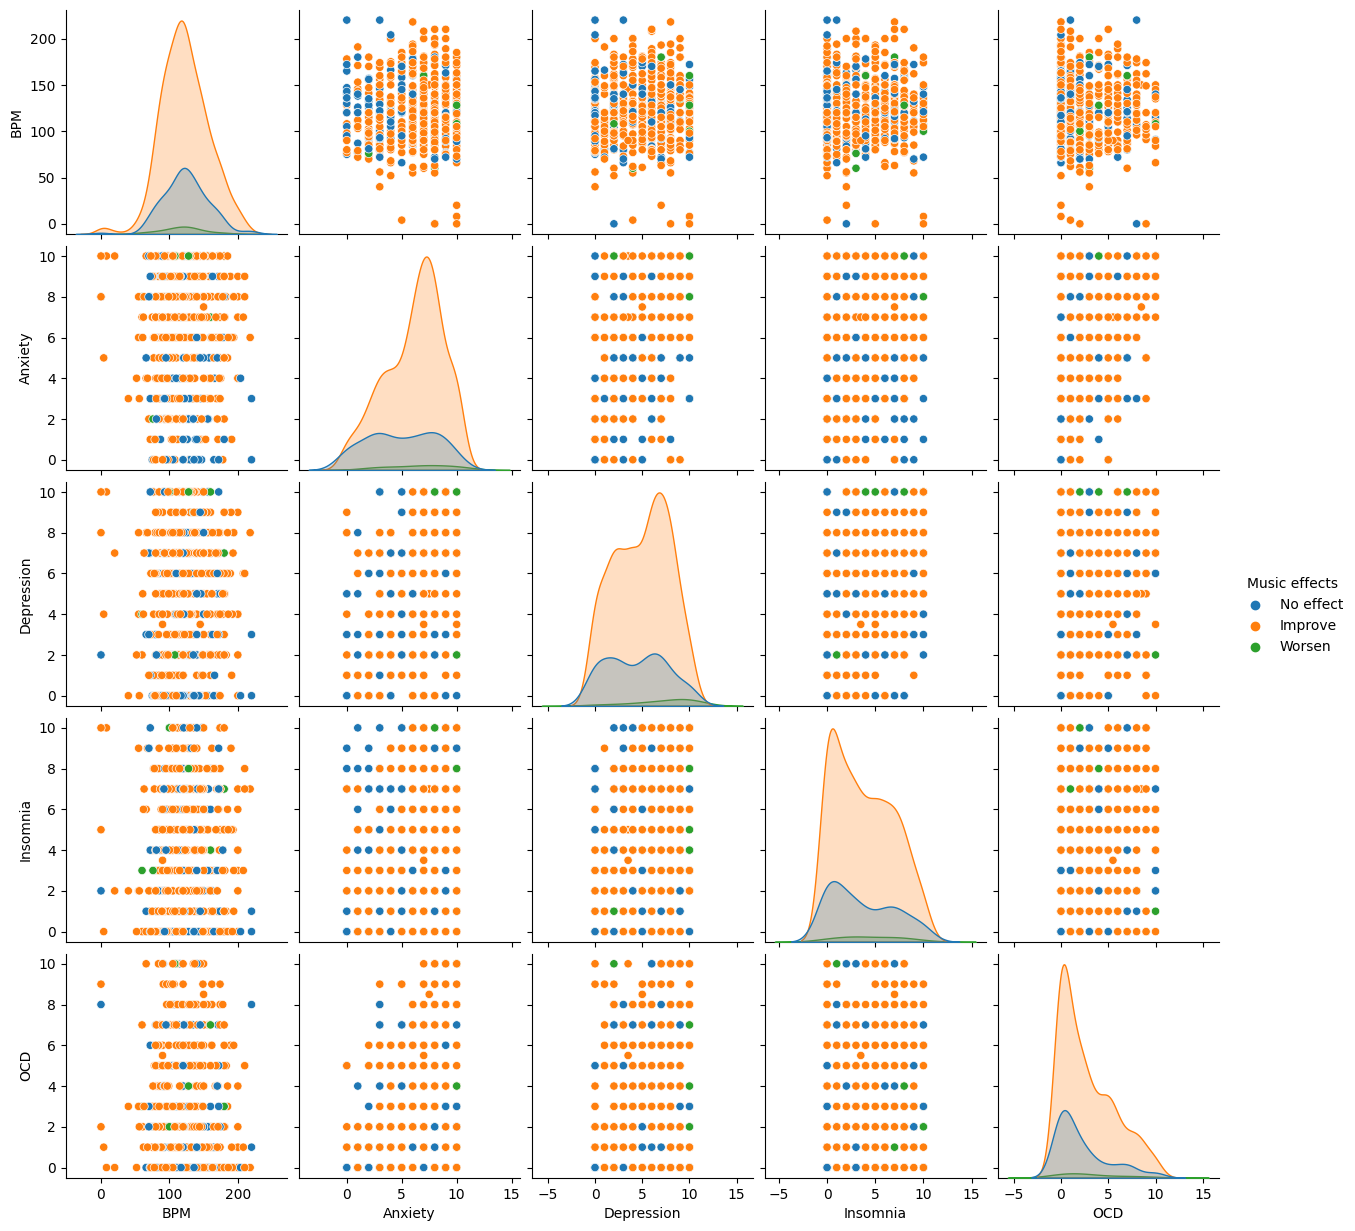

In [25]:
sns.pairplot(df2, hue="Music effects")

We are able to see that there're a lot of orange points than the other two colors' points, but it's hard to say if there's any influence came from the four variables(Anxiety, Depression, Insomnia, and OCD)

In [26]:
clf = DecisionTreeClassifier(max_leaf_nodes=10, random_state=1)

In [27]:
df2_train, df2_test = train_test_split(df2, train_size=0.9, random_state=2)

In [28]:
df2_train.head()

,BPM,Anxiety,Depression,Insomnia,OCD,Music effects
90,160.0,7.0,6.0,6.0,2.0,No effect
102,134.0,10.0,8.0,6.0,7.0,No effect
18,99.0,7.0,5.0,0.0,3.0,Improve
217,100.0,6.0,5.0,4.0,2.0,Improve
615,134.0,4.0,8.0,0.0,0.0,Improve


In [29]:
cols = ["BPM", "Anxiety", "Depression", "Insomnia", "OCD"]

In [30]:
clf.fit(df2_train[cols], df2_train["Music effects"])

DecisionTreeClassifier(max_leaf_nodes=10, random_state=1)

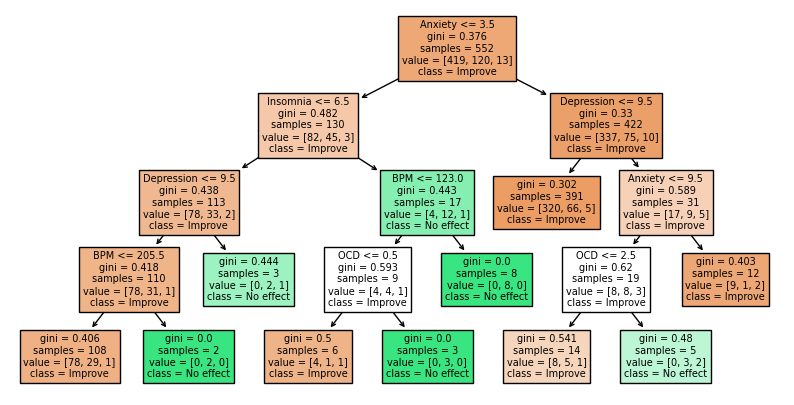

In [31]:
fig = plt.figure(figsize=(10, 5)) # reference, source 2
_ = plot_tree(clf, 
                   feature_names=clf.feature_names_in_,
                   class_names=clf.classes_,
                   filled=True)

In this DecisionTreeClassifier plot, almost all the variables can lead the results, and they are arranged in a uncertain way with no specific differences. At this time, I believe these conditions of mental health cannot lead to differences in music effects as well.

## Summary

In this project, I tried to analyze mainly three kinds of data: Age and frequency, BPM of music, and respondents' mental health condition. Unfortunately, all of these three fields of variables show to have only little relationship with final music effects.

In the case that we don't know what's the most influential factor that can lead to different results of music therapy, it's lucky to know that most of the results show music therapy is helpful. I hope we will be able to find out the most important factor one day.

## References

Your code above should include references.  Here is some additional space for references.

* What is the source of your dataset(s)?

Source 1: Turn yes/no to be 1/0
https://stackoverflow.com/questions/40901770/is-there-a-simple-way-to-change-a-column-of-yes-no-to-1-0-in-a-pandas-dataframe

Source 2: Change the size of plot trees
https://stackoverflow.com/questions/59447378/sklearn-plot-tree-plot-is-too-small

* List any other references that you found helpful.

Detect and exclude outliers
https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe

## Submission

Using the Share button at the top right, **enable Comment privileges** for anyone with a link to the project. Then submit that link on Canvas.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c0b5f455-d874-471d-a8c7-a32d5a546228' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>